In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import gc
import pandas as pd
import numpy as np
import re
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
gc.collect()

22

In [3]:
cd /content/gdrive/My Drive/dacon/lyrics

/content/gdrive/My Drive/dacon/lyrics


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_x.csv")
submission = pd.read_csv("sample_submission.csv")

In [5]:
train.text = train.text.str.lower()
test.text = test.text.str.lower()

In [6]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
tokenizer = RegexpTokenizer('\s+', gaps = True)
stopwords = set(stopwords.words('english'))

In [8]:
clear_punc = []
for t in range(len(train.text)):
  clear_punc.append(re.sub('[!@#$%^&“*()_+”=‘,./ª?\><;":`~]', ' ' ,train.text[t]))
train['clear_punc'] = clear_punc

In [9]:
clear_punc = []
for t in range(len(test.text)):
  clear_punc.append(re.sub('[!@#$%“^&*()_+=,‘./ª?\><;":`~]', ' ' ,test.text[t]))
test['clear_punc'] = clear_punc

In [10]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

In [11]:
train['length_text'] = train.clear_punc.apply(lambda x : len(x))
test['length_text'] = test.clear_punc.apply(lambda x : len(x))

In [12]:
def expand_contractions(tweet):
    tweet = re.sub(r"i’m", "i am", tweet)
    tweet = re.sub(r"i’d", "i would", tweet) 
    tweet = re.sub(r"i’ll", "i will", tweet)
    tweet = re.sub(r"i’ve", "i have", tweet)
    tweet = re.sub(r"you’re", "you are", tweet)
    tweet = re.sub(r"you’d", "you would", tweet)
    tweet = re.sub(r"you’ve", "you have", tweet)
    tweet = re.sub(r"you’ll", "you will", tweet)
    tweet = re.sub(r"y’know", "you know", tweet)  
    tweet = re.sub(r"y’all", "you all", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"we’re", "we are", tweet)
    tweet = re.sub(r"we’ve", "we have", tweet) 
    tweet = re.sub(r"we’d", "we would", tweet)
    tweet = re.sub(r"we’ll", "we will", tweet)
    tweet = re.sub(r"they’re", "they are", tweet)
    tweet = re.sub(r"they’d", "they would", tweet)
    tweet = re.sub(r"they’ve", "they have", tweet)
    tweet = re.sub(r"they’ll", "they will", tweet)
    tweet = re.sub(r"he’s", "he is", tweet)
    tweet = re.sub(r"he’ll", "he will", tweet)
    tweet = re.sub(r"she’s", "she is", tweet)
    tweet = re.sub(r"she’ll", "she will", tweet)
    tweet = re.sub(r"it’s", "it is", tweet)
    tweet = re.sub(r"it’ll", "it will", tweet)
    tweet = re.sub(r"isn’t", "is not", tweet)
    tweet = re.sub(r"who’s", "who is", tweet)
    tweet = re.sub(r"what’s", "what is", tweet)
    tweet = re.sub(r"that’s", "that is", tweet)
    tweet = re.sub(r"here’s", "here is", tweet)
    tweet = re.sub(r"there’s", "there is", tweet)
    tweet = re.sub(r"where’s", "where is", tweet) 
    tweet = re.sub(r"how’s", "how is", tweet)   
    tweet = re.sub(r"how’re", "how are", tweet)  
    tweet = re.sub(r"let’s", "let us", tweet)
    tweet = re.sub(r"won’t", "will not", tweet)
    tweet = re.sub(r"wasn’t", "was not", tweet)
    tweet = re.sub(r"aren’t", "are not", tweet)
    tweet = re.sub(r"couldn’t", "could not", tweet)
    tweet = re.sub(r"shouldn’t", "should not", tweet)
    tweet = re.sub(r"haven’t", "have not", tweet)
    tweet = re.sub(r"hasn’t", "has not", tweet)
    tweet = re.sub(r"wouldn’t", "would not", tweet)
    tweet = re.sub(r"weren’t", "were not", tweet)
    tweet = re.sub(r"ain’t", "am not", tweet)
    tweet = re.sub(r"don’t", "do not", tweet)
    tweet = re.sub(r"didn’t", "did not", tweet)
    tweet = re.sub(r"doesn’t", "does not", tweet)
    tweet = re.sub(r"can’t", "cannot", tweet)
    tweet = re.sub(r"should’ve", "should have", tweet)
    tweet = re.sub(r"would’ve", "would have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub("i've", 'i have', tweet)
    tweet = re.sub("i'd", 'i had', tweet)
    return tweet

In [13]:
train['clear_punc'] = train.clear_punc.apply(expand_contractions)
test['clear_punc'] = test.clear_punc.apply(expand_contractions)

In [14]:
train.clear_punc = train.clear_punc.str.replace('-', ' ')
train.clear_punc = train.clear_punc.str.replace("'", '')
train.clear_punc = train.clear_punc.str.replace("’", '')
train.clear_punc = train.clear_punc.str.replace("’", '')
test.clear_punc = test.clear_punc.str.replace('-', ' ')
test.clear_punc = test.clear_punc.str.replace("'", '')
test.clear_punc = test.clear_punc.str.replace("’", '')
test.clear_punc = test.clear_punc.str.replace("’", '')

In [15]:
train.clear_punc = train.clear_punc.str.replace("’", '')
train.clear_punc = train.clear_punc.str.replace("’", '')
train.clear_punc = train.clear_punc.str.replace("—", ' ')
train.clear_punc = train.clear_punc.str.replace("”", ' ')
test.clear_punc = test.clear_punc.str.replace("’", '')
test.clear_punc = test.clear_punc.str.replace("’", '')
test.clear_punc = test.clear_punc.str.replace("—", ' ')
test.clear_punc = test.clear_punc.str.replace("”", ' ')

In [ ]:
#train.clear_punc = train.clear_punc.apply(remove_stopwords)
#test.clear_punc = test.clear_punc.apply(remove_stopwords)

In [16]:
token_text = []

for t in train.clear_punc:
  temp = tokenizer.tokenize(t)
  #temp = [word for word in temp if not word in stopwords]
  token_text.append(temp)

train['token_text'] = token_text

In [17]:
token_text = []

for t in test.clear_punc:
  temp = tokenizer.tokenize(t)
  #temp = [word for word in temp if not word in stopwords]
  token_text.append(temp)

test['token_text'] = token_text

In [18]:
train['length_token'] = train.token_text.apply(lambda x : len(x))
test['length_token'] = test.token_text.apply(lambda x : len(x))

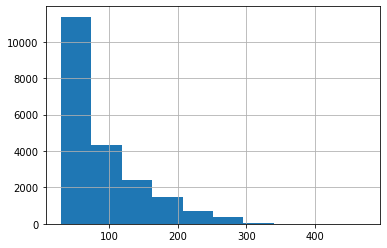

In [ ]:
train.length_token.hist()

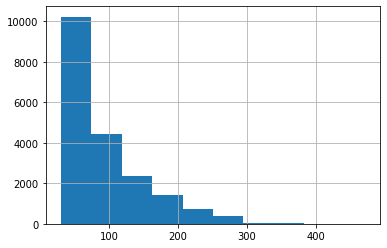

In [ ]:
test.length_token.hist()

In [ ]:
test.length_token.min()

30

In [34]:
train2 = train

In [39]:
train = train.loc[train.length_token > 15]

In [40]:
train.index = range(train.shape[0])

In [38]:
train.loc[train.length_token > 15].author.value_counts()

3    9338
0    8636
2    6930
1    5520
4    5056
Name: author, dtype: int64

In [19]:
train.author.value_counts()

3    15063
0    13235
2    11554
4     7805
1     7222
Name: author, dtype: int64

In [20]:
train.groupby('author').length_token.mean()

author
0    38.053721
1    57.761423
2    40.568201
3    41.797252
4    42.005381
Name: length_token, dtype: float64

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
stopwords = ['a','an','the','am','is','are','were','was']

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.token_text)

In [42]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 34206
등장 빈도가 5번 이하인 희귀 단어의 수: 21413
단어 집합에서 희귀 단어의 비율: 62.600128632403674
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9721078481729615


In [43]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12794


In [44]:
tokenizer = Tokenizer(vocab_size,oov_token = 'oov')
tokenizer.fit_on_texts(train.token_text)

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [45]:
below_threshold_len(250, train.token_text)

전체 샘플 중 길이가 250 이하인 샘플의 비율: 98.64430665163472


In [46]:
y = np.array([x for x in train['author']])

In [47]:
max_len =  250

In [48]:
seq = tokenizer.texts_to_sequences(train.token_text)
seq = pad_sequences(seq, maxlen = max_len, padding = 'post')

In [49]:
target = tokenizer.texts_to_sequences(test.token_text)
target = pad_sequences(target, maxlen = max_len, padding = 'post')

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.metrics import log_loss, accuracy_score
import keras.backend as K

In [50]:
  model = Sequential()
  model.add(Embedding(vocab_size , 128, input_length = max_len))
  model.add(Dropout(.3))
  model.add(Conv1D(64, 5, activation = 'relu', kernel_regularizer = l2(0.001)))
  model.add(MaxPooling1D())
  model.add(Dropout(.3))
  model.add(LSTM(64, dropout = .3, return_sequences=True))
  #model.add(Flatten())
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(.3))
  #model.add(Dense(16, activation = 'relu'))
  model.add(Dense(5, activation = 'softmax'))
  model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 128)          1637632   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 123, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 123, 64)           33024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)               

In [51]:
model.compile(optimizer = RMSprop(lr = .0005), metrics = 'accuracy', loss = 'sparse_categorical_crossentropy')
callback_ear = [EarlyStopping(monitor = 'val_accuracy', patience = 2, mode = 'max', verbose = 1), ModelCheckpoint(filepath = '1201_1.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max',verbose = 1)]
model.fit(seq, y, epochs = 20, validation_split = .1, shuffle = True, batch_size = 32, callbacks=callback_ear)

Epoch 1/20
998/998 [==============================] - ETA: 0s - loss: 1.3494 - accuracy: 0.4397
Epoch 00001: val_accuracy improved from -inf to 0.62007, saving model to 1201_1.h5
998/998 [==============================] - 18s 18ms/step - loss: 1.3494 - accuracy: 0.4397 - val_loss: 1.0135 - val_accuracy: 0.6201
Epoch 2/20
998/998 [==============================] - ETA: 0s - loss: 0.9508 - accuracy: 0.6345
Epoch 00002: val_accuracy improved from 0.62007 to 0.67559, saving model to 1201_1.h5
998/998 [==============================] - 17s 17ms/step - loss: 0.9508 - accuracy: 0.6345 - val_loss: 0.8573 - val_accuracy: 0.6756
Epoch 3/20
996/998 [============================>.] - ETA: 0s - loss: 0.8014 - accuracy: 0.7026
Epoch 00003: val_accuracy improved from 0.67559 to 0.72971, saving model to 1201_1.h5
998/998 [==============================] - 17s 17ms/step - loss: 0.8011 - accuracy: 0.7027 - val_loss: 0.7562 - val_accuracy: 0.7297
Epoch 4/20
995/998 [============================>.] - ETA:

In [52]:
model1 = load_model('1201_1.h5')

In [53]:
pred1 = model1.predict(target)

## Model 2


In [54]:
model = Sequential()
model.add(Embedding(vocab_size , 128, input_length = max_len))
model.add(SpatialDropout1D(.5))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(.5))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 128)          1637632   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          98816     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 1,737,093
Trainable params: 1,737,093
Non-trainable params: 0
____________________________________________

In [55]:
model.compile(optimizer = RMSprop(lr = .0005), metrics = 'accuracy', loss = 'sparse_categorical_crossentropy')
callback_ear = [EarlyStopping(monitor = 'val_accuracy', patience = 2, mode = 'max', verbose = 1), ModelCheckpoint(filepath = '1201_2.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max',verbose = 1)]
model.fit(seq, y, epochs = 30, validation_split = .1, shuffle = True, batch_size = 32, callbacks= callback_ear)

Epoch 1/30
998/998 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.4167
Epoch 00001: val_accuracy improved from -inf to 0.58822, saving model to 1201_2.h5
998/998 [==============================] - 29s 29ms/step - loss: 1.3617 - accuracy: 0.4167 - val_loss: 1.0253 - val_accuracy: 0.5882
Epoch 2/30
997/998 [============================>.] - ETA: 0s - loss: 0.9545 - accuracy: 0.6215
Epoch 00002: val_accuracy improved from 0.58822 to 0.69053, saving model to 1201_2.h5
998/998 [==============================] - 28s 28ms/step - loss: 0.9543 - accuracy: 0.6217 - val_loss: 0.8087 - val_accuracy: 0.6905
Epoch 3/30
997/998 [============================>.] - ETA: 0s - loss: 0.7776 - accuracy: 0.7054
Epoch 00003: val_accuracy improved from 0.69053 to 0.74831, saving model to 1201_2.h5
998/998 [==============================] - 28s 28ms/step - loss: 0.7778 - accuracy: 0.7054 - val_loss: 0.6870 - val_accuracy: 0.7483
Epoch 4/30
998/998 [==============================] - ETA:

In [56]:
model2 = load_model('1201_2.h5')

In [57]:
pred2 = model2.predict(target)

In [58]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length= max_len))
model.add(Dropout(.2))
model.add(Bidirectional(GRU(64, dropout = .4,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(.4))
model.add(Dense(5, activation = 'softmax'))

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 128)          1637632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 128)          74496     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 1,712,773
Trainable params: 1,712,773
Non-trainable params: 0
____________________________________________

In [60]:
model.compile(optimizer = RMSprop(lr = .0005), metrics = 'accuracy', loss = 'sparse_categorical_crossentropy')
callback_ear = [EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max', verbose = 1), ModelCheckpoint(filepath = '1201_3.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max',verbose = 1)]

In [61]:
model.fit(seq, y, epochs = 50, validation_split = .1, shuffle = True, batch_size = 32, callbacks=callback_ear)

Epoch 1/50
998/998 [==============================] - ETA: 0s - loss: 1.3619 - accuracy: 0.4219
Epoch 00001: val_accuracy improved from -inf to 0.59301, saving model to 1201_3.h5
998/998 [==============================] - 29s 29ms/step - loss: 1.3619 - accuracy: 0.4219 - val_loss: 1.0394 - val_accuracy: 0.5930
Epoch 2/50
997/998 [============================>.] - ETA: 0s - loss: 0.9483 - accuracy: 0.6284
Epoch 00002: val_accuracy improved from 0.59301 to 0.69307, saving model to 1201_3.h5
998/998 [==============================] - 27s 28ms/step - loss: 0.9480 - accuracy: 0.6286 - val_loss: 0.8142 - val_accuracy: 0.6931
Epoch 3/50
998/998 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.7172
Epoch 00003: val_accuracy improved from 0.69307 to 0.74915, saving model to 1201_3.h5
998/998 [==============================] - 28s 28ms/step - loss: 0.7563 - accuracy: 0.7172 - val_loss: 0.6767 - val_accuracy: 0.7492
Epoch 4/50
997/998 [============================>.] - ETA:

In [62]:
model3 = load_model('1201_3.h5')

In [63]:
pred3 = model3.predict(target)

In [64]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length= max_len))
model.add(Dropout(.3))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu'))
model.add(Dropout(.3))
model.add(Bidirectional(GRU(64, dropout = .4,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(.4))
model.add(Dense(5, activation = 'softmax'))

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 128)          1637632   
_________________________________________________________________
dropout_9 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 64)           41024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 250, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 128)          49920     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [66]:
model.compile(optimizer = RMSprop(lr = .0005), metrics = 'accuracy', loss = 'sparse_categorical_crossentropy')
callback_ear = [EarlyStopping(monitor = 'val_accuracy', patience = 3, mode = 'max', verbose = 1), ModelCheckpoint(filepath = '1201_4.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max',verbose = 1)]

In [67]:
model.fit(seq, y, epochs = 50, validation_split = .1, shuffle = True, batch_size = 32,callbacks=callback_ear)

Epoch 1/50
997/998 [============================>.] - ETA: 0s - loss: 1.3588 - accuracy: 0.4025
Epoch 00001: val_accuracy improved from -inf to 0.58681, saving model to 1201_4.h5
998/998 [==============================] - 30s 30ms/step - loss: 1.3587 - accuracy: 0.4025 - val_loss: 1.0426 - val_accuracy: 0.5868
Epoch 2/50
997/998 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.6263
Epoch 00002: val_accuracy improved from 0.58681 to 0.68997, saving model to 1201_4.h5
998/998 [==============================] - 30s 30ms/step - loss: 0.9265 - accuracy: 0.6263 - val_loss: 0.8062 - val_accuracy: 0.6900
Epoch 3/50
997/998 [============================>.] - ETA: 0s - loss: 0.7426 - accuracy: 0.7167
Epoch 00003: val_accuracy improved from 0.68997 to 0.73534, saving model to 1201_4.h5
998/998 [==============================] - 30s 30ms/step - loss: 0.7426 - accuracy: 0.7167 - val_loss: 0.7057 - val_accuracy: 0.7353
Epoch 4/50
998/998 [==============================] - ETA:

In [68]:
model4 = load_model('1201_4.h5')

In [69]:
pred4 = model4.predict(target)

In [70]:
pred = (pred1 * pred2 * pred3 * pred4) ** .25

In [71]:
submission[['0','1','2','3','4']] = pred

In [72]:
submission.to_csv('1201_2.csv', index = False)